# Predicting with EEG refined

In [157]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, create_dataset_eeg, create_dataset_eeg_old
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.decomposition import PCA

### Utilities

In [2]:
def drop_nans_based_on_column(dataframe, column): 
    nans_indices = []
    for index, value in enumerate(dataframe.loc[:,column].isna()):
        if value==True: 
            nans_indices.append(index)
    print('dropped', len(nans_indices), 'samples')

    return dataframe.drop(nans_indices, axis=0)

In [3]:
def drop_nulls_based_on_column(dataframe, column): 
    nulls_indices = []
    for index, value in enumerate(dataframe.loc[:,column].isnull()):
        if value==True: 
            nulls_indices.append(index)
    print('dropped', len(nulls_indices), 'samples')

    return dataframe.drop(nulls_indices, axis=0)

In [4]:
def get_statistics_column(dataframe, column, show_histo=True):
    
    values = set(dataframe.loc[:,column].values)
    values_dict = {}
    for value in values: 
        values_dict[value] = len(dataframe.groupby(column).get_group(value).index)
    if show_histo == True:
        plt.bar(range(len(values_dict)), list(values_dict.values()), align='center', color='lightblue')
        plt.xticks(range(len(values_dict)), range(1,len(values_dict)+1))
        plt.show()
    return values_dict

In [5]:
# helper function to get params for model to be inserted into sklearn pipeline
def make_pipe_model_params(params): 
    new_params = {}
    for key in params.keys(): 
        newkey = 'model_class__'+key
        new_params[newkey] = params[key]
    return new_params

In [158]:
# helper function to get params for model to be inserted into sklearn pipeline
def make_pipe_model_params_pca(params): 
    new_params = {}
    for key in params.keys():
        if key != 'n_components':
            newkey = 'model_class__'+key
            new_params[newkey] = params[key]
        else:
            newkey = 'pca__'+key
            new_params[newkey] = params[key]
    return new_params

In [23]:
# Helper function for cross-validation in One-Class Classification
def cv_one_class_classification(model, data, labels, n_splits = 5):
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.metrics import f1_score
    '''
    model: must be a sklearn object with .fit and .predict methods
    data: the X matrix containing the features, can be a pd.DataFrame or a np object (array or matrix)
    labels: y, can be a pd.DataFrame or a np array
    n_splits: number of desired folds
    => returns array of mean suqared error calculated on each fold
    '''
    kf = KFold(n_splits=n_splits, shuffle=True)
    data = np.array(data)
    labels = np.array(labels)
    scores = {
        'balanced_accuracy' : [],
        'f1_score': []
    }
    i = 1
    for train, test in kf.split(data):
        print("Split: {}".format(i), end="\r")
        X_train, X_test, y_train, y_test = data[train], data[test], labels[train], labels[test]
        model.fit(X=X_train, y=y_train)
        pred = model.predict(X_test)
        bal_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=pred)
        f1 = f1_score(y_true=y_test, y_pred=pred)
        scores['balanced_accuracy'].append(bal_accuracy)
        scores['f1_score'].append(f1)
        i = i+1
    return scores

In [165]:
def one_class_classify_CV(X, y, models={'LinearSVC': 5}, CV_n_splits = 5, verbose=2, impute_strategy='mean'):
    '''
    implements CV using 'CV helper function for One-Class Classification'
    input: dataset X, label y, dict of models to be used as 'model name' : number of combinations of parameters
    output: 2 dictionaries 
    '''
    # import libraries
    import random
    from sklearn.model_selection import ParameterGrid
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    
    # results list to be returned
    results= {}
    bests= {}
    
    
    # Ridge Classification ----------------------------------------------------------------------------------------------
    if 'RidgeClassifier' in models.keys(): 
        # model class
        from sklearn.linear_model import RidgeClassifier
        model_class_name = 'RidgeClassifier'
        model_class = RidgeClassifier()
        #create list for model class results
        model_class_results = []
        # get number of combinations
        n_param_combinations = models.get(model_class_name)
        # parameter grid for the model class
        param_grid ={
            'alpha' : [0.5, 0.7, 1.0, 1.1, 1.3, 1.5, 2.0]
            }
        #create list of parameter combinations
        p_grids = list(ParameterGrid(param_grid))
        total_combinations = len(p_grids)
        if n_param_combinations >= total_combinations: 
            print('trying all possible combiations of parameters for ',model_class_name)
        else: 
            print('trying ', n_param_combinations,' possible combiations of parameters for ',model_class_name)
        # loop over parameter combinations
        i = 1
        while (i <= n_param_combinations) and (i <= total_combinations):
            try:
                params = random.choice(p_grids)
                print(params)
                p_grids.remove(params)
                pipe = Pipeline([('imputing',SimpleImputer(strategy=impute_strategy)),('scaling', StandardScaler()), ('model_class', model_class)])
                pipe_params = make_pipe_model_params(params)
                model = pipe.set_params(**pipe_params)
                scores = cv_one_class_classification(model=model, data=X, labels=y, n_splits=CV_n_splits)
                model_class_results.append([params, scores])
            except ValueError: 
                print('non supported combination of parameters')
                model_class_results.append(['non-valid',0])
            print('done ', i , ' out of ',n_param_combinations, ' combinations')
            i+=1
        # put model class results into dictionary
        results[model_class_name] = model_class_results
        print(model_class_name, ' done')
    
    # Linear SVC ----------------------------------------------------------------------------------------------
    if 'LinearSVC' in models.keys(): 
        # model class
        from sklearn.svm import LinearSVC
        model_class_name = 'LinearSVC'
        model_class = LinearSVC()
        #create list for model class results
        model_class_results = []
        # get number of combinations
        n_param_combinations = models.get(model_class_name)
        # parameter grid for the model class
        param_grid ={
            'penalty': ['l1','l2'],
            'loss' : ['squared_hinge','hinge'],
            'dual' : [False],                   #according to scikit-learn better False if n_samples > n_features
            'tol' : [0.0001],
            'C': [1.0 , 2.0 , 5.0 , 10.0, 0.5, 0.2],
            #'multi_class' : ['ovr', 'crammer_singer'],
            'fit_intercept' : [False],           #since data is assumed to be already centered 
            #'intercept_scaling'=[1], 
            'class_weight':['balanced'], 
            #'verbose'=[0], 
            #'random_state'=None, 
            'max_iter' : [1000],
            'verbose' : [verbose], 
            'n_components' : [1300, 1100, 1000,  800, 600, 500, 300, 200, 150]
            }
        #create list of parameter combinations
        p_grids = list(ParameterGrid(param_grid))
        total_combinations = len(p_grids)
        if n_param_combinations >= total_combinations: 
            print('trying all possible combiations of parameters for ',model_class_name)
        else: 
            print('trying ', n_param_combinations,' possible combiations of parameters for ',model_class_name)
        # loop over parameter combinations
        i = 1
        while (i <= n_param_combinations) and (i <= total_combinations):
            try:
                params = random.choice(p_grids)
                print(params)
                p_grids.remove(params)
                pipe = Pipeline([('imputing',SimpleImputer(strategy=impute_strategy)),('scaling', StandardScaler()), ('pca',PCA()),('model_class', model_class)])
                pipe_params = make_pipe_model_params_pca(params)
                model = pipe.set_params(**pipe_params)
                scores = cv_one_class_classification(model=model, data=X, labels=y, n_splits=CV_n_splits)
                model_class_results.append([params, scores])
            except ValueError: 
                print('non supported combination of parameters')
                model_class_results.append(['non-valid',0])
            print('done ', i , ' out of ',n_param_combinations, ' combinations')
            i+=1
        # put model class results into dictionary
        results[model_class_name] = model_class_results
        print(model_class_name, ' done')
        
    # SVC --------------------------------------------------------------------------------------------------- 
    if 'SVC' in models.keys(): 
        # model class
        from sklearn.svm import SVC
        model_class_name = 'SVC'
        model_class = SVC()
        #create list for model class results
        model_class_results = []
        # get number of combinations
        n_param_combinations = models.get(model_class_name)
        # parameter grid for the model class
        param_grid ={
            'C' : [1.0 , 2.0 , 5.0 , 10.0, 0.5, 0.2],
            'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
            'coef0': [0.0, 0.1, 0.2, 0.5],
            'class_weight':['balanced'], 
            'shrinking' : [True, False],
            'verbose' : [verbose], 
            'n_components' : [1300, 1100, 1000,  800, 600, 500, 300, 200, 150]
            }
        #create list of parameter combinations
        p_grids = list(ParameterGrid(param_grid))
        total_combinations = len(p_grids)
        if n_param_combinations >= total_combinations: 
            print('trying all possible combiations of parameters for ',model_class_name)
        else: 
            print('trying ', n_param_combinations,' possible combiations of parameters for ',model_class_name)     
        # loop over parameter combinations
        i = 1
        while (i <= n_param_combinations) and (i <= total_combinations):
            try:
                params = random.choice(p_grids)
                p_grids.remove(params)
                pipe = Pipeline([('imputing',SimpleImputer(strategy=impute_strategy)),('scaling', StandardScaler()),('pca',PCA()),('model_class', model_class)])
                pipe_params = make_pipe_model_params_pca(params)
                model = pipe.set_params(**pipe_params)
                scores = cv_one_class_classification(model=model, data=X, labels=y, n_splits=CV_n_splits)
                model_class_results.append([params, scores])
            except ValueError: 
                print('non supported combination of parameters')
                model_class_results.append(['non-valid', 0])
            print('done ', i , ' out of ',n_param_combinations, ' combinations')
            i+=1
        # put model class results into dictionary
        results[model_class_name] = model_class_results
        print(model_class_name, ' done')
    
    # Extra Trees classifier ------------------------------------------------------------------------------------
    if 'ExtraTreesClassifier' in models.keys(): 
        # model class 
        from sklearn.ensemble import ExtraTreesClassifier
        model_class_name = 'ExtraTreesClassifier'
        model_class = ExtraTreesClassifier()
        #create list for model class results
        model_class_results = []
        # gte numbr of combinations
        n_param_combinations = models.get(model_class_name)
        # parameter grid for the model class
        param_grid ={
            'n_estimators' : [200, 250, 300],
            'criterion' : ['gini', 'entropy'],
            'min_samples_split' : [2, 3, 4],
            'bootstrap' : [True, False],
            'class_weight' : ['balanced', 'balanced_subsample'],
            'verbose' : [verbose],
            'n_jobs' : [3]
            }
        #create list of parameter combinations
        p_grids = list(ParameterGrid(param_grid))
        total_combinations = len(p_grids)
        if n_param_combinations >= total_combinations: 
            print('trying all possible combiations of parameters for ',model_class_name)
        else: 
            print('trying ', n_param_combinations,' possible combiations of parameters for ',model_class_name)    
        # loop over parameter combinations
        i = 1
        while (i <= n_param_combinations) and (i <= total_combinations):
            try:
                params = random.choice(p_grids)
                p_grids.remove(params)
                pipe = Pipeline([('imputing',SimpleImputer(strategy=impute_strategy)),('scaling', StandardScaler()), ('model_class', model_class)])
                pipe_params = make_pipe_model_params(params)
                model = pipe.set_params(**pipe_params)
                scores = cv_one_class_classification(model=model, data=X, labels=y, n_splits=CV_n_splits)
                model_class_results.append([params, scores])
            except ValueError: 
                print('non supported combination of parameters')
                model_class_results.append(['non-valid', 0])
            print('done ', i , ' out of ',n_param_combinations, ' combinations')
            i+=1
        # put model class results into dictionary
        results[model_class_name] = model_class_results
        print(model_class_name, ' done')
        
    # Random Forest classifier ----------------------------------------------------------------------------------
    if 'RandomForestClassifier' in models.keys(): 
        # import model class 
        from sklearn.ensemble import RandomForestClassifier
        model_class_name = 'RandomForestClassifier'
        model_class = RandomForestClassifier()
        #create list for model class results
        model_class_results = []
        # gte numbr of combinations
        n_param_combinations = models.get(model_class_name)
        # parameter grid for the model class
        param_grid ={
            'n_estimators' : [150, 175, 200, 250],
            'criterion' : ['gini', 'entropy'],
            'min_samples_split' : [2, 3,4],
            'bootstrap' : [True, False],
            'class_weight' : ['balanced', 'balanced_subsample'],
            'verbose' : [verbose],
            'n_jobs' : [3]
            }
        #create list of parameter combinations
        p_grids = list(ParameterGrid(param_grid))
        total_combinations = len(p_grids)
        if n_param_combinations >= total_combinations: 
            print('trying all possible combiations of parameters for ',model_class_name)
        else: 
            print('trying ', n_param_combinations,' possible combiations of parameters for ',model_class_name)
        # loop over parameter combinations
        i = 1
        while (i <= n_param_combinations) and (i <= total_combinations):
            try:
                params = random.choice(p_grids)
                p_grids.remove(params)
                pipe = Pipeline([('imputing',SimpleImputer(strategy=impute_strategy)),('scaling', StandardScaler()), ('model_class', model_class)])
                pipe_params = make_pipe_model_params(params)
                model = pipe.set_params(**pipe_params)
                scores = cv_one_class_classification(model=model, data=X, labels=y, n_splits=CV_n_splits)
                model_class_results.append([params, scores])
            except ValueError: 
                print('non supported combination of parameters')
                model_class_results.append(['non-valid', 0])
            print('done ', i , ' out of ',n_param_combinations, ' combinations')
            i+=1 
        # put model class results into dictionary
        results[model_class_name] = model_class_results
        print(model_class_name, ' done')
    
    # AdaBoost classifier -----------------------------------------------------------------------------------
    if 'AdaBoostClassifier' in models.keys(): 
        # import model class 
        from sklearn.ensemble import AdaBoostClassifier
        from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
        model_class_name = 'AdaBoostClassifier'
        model_class = AdaBoostClassifier()
        #create list for model class results
        model_class_results = []
        #get number of combinations
        n_param_combinations = models.get(model_class_name)
        # parameter grid for the model class
        param_grid ={
            'base_estimator' : [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
            'n_estimators' : [75, 100, 150],
            'learning_rate' : [1.0, 1.5, 2.0, 1.75]
            }
        #create list of parameter combinations
        p_grids = list(ParameterGrid(param_grid))
        total_combinations = len(p_grids)
        if n_param_combinations >= total_combinations: 
            print('trying all possible combiations of parameters for ',model_class_name)
        else: 
            print('trying ', n_param_combinations,' possible combiations of parameters for ',model_class_name)       
        # loop over parameter combinations
        i = 1
        while (i <= n_param_combinations) and (i <= total_combinations):
            try:
                params = random.choice(p_grids)
                p_grids.remove(params)
                pipe = Pipeline([('imputing',SimpleImputer(strategy=impute_strategy)),('scaling', StandardScaler()), ('model_class', model_class)])
                pipe_params = make_pipe_model_params(params)
                model = pipe.set_params(**pipe_params)
                scores = cv_one_class_classification(model=model, data=X, labels=y, n_splits=CV_n_splits)
                model_class_results.append([params, scores])
            except ValueError: 
                print('non supported combination of parameters')
                model_class_results.append(['non-valid', 0])
            print('done ', i , ' out of ',n_param_combinations, ' combinations')
            i+=1
        # put model class results into dictionary
        results[model_class_name] = model_class_results
        print(model_class_name, ' done')
    # XGBoost classifier -----------------------------------------------------------------------------------
    if 'XGBClassifier' in models.keys(): 
        # import model class 
        from xgboost import XGBClassifier
        model_class_name = 'XGBClassifier'
        model_class = XGBClassifier()
        #create list for model class results
        model_class_results = []
        #get number of combinations
        n_param_combinations = models.get(model_class_name)
        # parameter grid for the model class
        param_grid ={
            'max_depth' : [1,2,3], 
            'learning_rate' : [0.1,0.2,0.3,0.4],
            'n_estimators' : [150,200,250, 300],
            'verbosity' : [verbose],
            'objective' : ['binary:logistic'],
            'n_jobs' : [3], 
            'gamma' : [0, 0.1, 0.5, 1],
            'reg_alpha' : [0, 0.5, 1],
            'reg_alpha' : [0, 0.5, 1, 2],
            'scale_pos_weight': [6.6]     # computed as negative samples/positive samples
            }
        #create list of parameter combinations
        p_grids = list(ParameterGrid(param_grid))
        total_combinations = len(p_grids)
        if n_param_combinations >= total_combinations: 
            print('trying all possible combiations of parameters for ',model_class_name)
        else: 
            print('trying ', n_param_combinations,' possible combiations of parameters for ',model_class_name)       
        # loop over parameter combinations
        i = 1
        while (i <= n_param_combinations) and (i <= total_combinations):
            try:
                params = random.choice(p_grids)
                p_grids.remove(params)
                pipe = Pipeline([('imputing',SimpleImputer(strategy=impute_strategy)),('scaling', StandardScaler()), ('model_class', model_class)])
                pipe_params = make_pipe_model_params(params)
                model = pipe.set_params(**pipe_params)
                scores = cv_one_class_classification(model=model, data=X, labels=y, n_splits=CV_n_splits)
                model_class_results.append([params, scores])
            except ValueError: 
                print('non supported combination of parameters')
                model_class_results.append(['non-valid', 0])
            print('done ', i , ' out of ',n_param_combinations, ' combinations')
            i+=1
        # put model class results into dictionary
        results[model_class_name] = model_class_results
        print(model_class_name, ' done') 
    
    for model_class_name in results.keys(): 
        means_b_accuracy = []
        means_f1_score = []
        medians_b_accuracy  = []
        medians_f1_score = []
        for params, scores in results[model_class_name]:
            if params != 'non-valid':
                means_b_accuracy.append(np.mean(np.asarray(scores['balanced_accuracy'])))
                means_f1_score.append(np.mean(np.asarray(scores['f1_score'])))
                medians_b_accuracy.append(np.median(np.asarray(scores['balanced_accuracy'])))
                medians_f1_score.append(np.median(np.asarray(scores['f1_score'])))
            else:
                means_b_accuracy.append(-1)
                means_f1_score.append(-1)
                medians_b_accuracy.append(-1)
                medians_f1_score.append(-1)
                
        index_b_accuracy = np.argmax(np.asarray(means_b_accuracy))
        index_f1_score = np.argmax(np.asarray(means_f1_score))
        
        best_score_b_acc_mean = np.asarray(means_b_accuracy)[index_b_accuracy]
        best_score_f1_score_mean = np.asarray(means_f1_score)[index_f1_score]
        
        best_score_b_acc_median = np.asarray(medians_b_accuracy)[index_b_accuracy]
        best_score_f1_score_median = np.asarray(medians_f1_score)[index_f1_score]
        
        best_params_b_acc = results[model_class_name][index_b_accuracy][0]
        best_params_f_score = results[model_class_name][index_f1_score][0]
        
        
        bests[model_class_name] ={
            'balanced_accuracy':{'mean':best_score_b_acc_mean,'median': best_score_b_acc_median,'parameters':best_params_b_acc, 
                        'f1_score': {'mean':np.asarray(means_f1_score)[index_b_accuracy],'median':np.asarray(medians_f1_score)[index_b_accuracy]} },

            'f1_score':{'mean':best_score_f1_score_mean,'median': best_score_f1_score_median,'parameters':best_params_f_score, 
                        'balanced_accuracy': {'mean':np.asarray(means_b_accuracy)[index_f1_score],'median':np.asarray(medians_b_accuracy)[index_f1_score]} },

        }
    return results, bests

### Importing data 

In [9]:
#import data non-extensive (only clusters and ratios)
eeg_clusters = create_dataset_eeg(SCORE = 'Age', clusters = True, ratios = True)

#drop samples with Nan in 'DX_01_Cat'
eeg_clusters = drop_nans_based_on_column(eeg_clusters, 'DX_01_Cat')

eeg_clusters.shape

dropped 1 samples


(1305, 1505)

In [10]:
eeg_clusters

,id,Age,DX_01_Cat,DX_01_Sub,DX_01,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,eyesclosed_fband_delta_absmean_mpari,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
0,NDARFM080VAF,7.623203,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,7.519803,7.043891,6.528158,9.633529,9.989483,...,0.125251,0.125441,0.133882,0.072295,0.080103,0.161771,0.162017,0.172919,0.093375,0.086876
1,NDARVG148WHV,10.835158,Neurodevelopmental Disorders,Communication Disorder,Language Disorder,2.346685,3.945786,2.962716,3.440606,3.565384,...,0.859637,0.476218,0.527328,0.440019,0.506425,0.861336,0.477159,0.528370,0.440889,0.404930
2,NDARUY876VL1,7.987451,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Hyperactive/Impulsive Type,1.281869,1.229748,1.905450,1.768091,1.484286,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
3,NDARYU323ZDJ,8.096851,Anxiety Disorders,NaN,Separation Anxiety,3.109075,4.803264,2.873502,2.644382,3.884837,...,0.350058,0.265802,0.342563,0.287435,0.272517,0.352119,0.267367,0.344580,0.289128,0.278771
4,NDARYP516VUU,10.758156,No Diagnosis Given,NaN,No Diagnosis Given,3.736577,5.970049,3.462826,4.225793,6.973617,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,NDARYM334BZ5,16.119438,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Inattentive Type,3.743134,3.795633,3.286381,2.779438,3.539956,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282
1302,NDARJJ817UP1,9.126397,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,5.029233,8.495798,8.156703,9.869929,10.167374,...,0.773345,0.620713,0.568809,0.370741,0.490682,0.722092,0.579575,0.531112,0.346170,0.423813
1303,NDARYZ986HEW,7.563084,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,2.830657,5.259391,6.724664,4.745513,5.885628,...,0.954900,0.511584,0.301190,0.360761,0.593757,0.585975,0.313934,0.184825,0.221382,0.238841
1304,NDARPM572ZZV,9.832762,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,3.465377,4.039687,2.988368,5.326977,6.712658,...,0.252401,0.395706,0.427291,0.195140,0.134998,0.283403,0.444309,0.479773,0.219108,0.154441


### Statistics

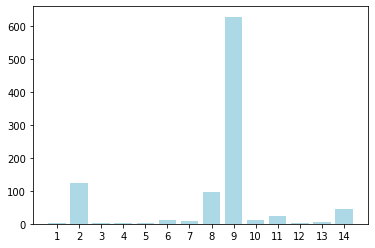

{'Other Conditions That May Be a Focus of Clinical Attention': 3,
 'No Diagnosis Given': 125,
 'Schizophrenia Spectrum and other Psychotic Disorders': 3,
 'Neurocognitive Disorders': 2,
 'Disruptive, Impulse Control and Conduct Disorders': 3,
 'Trauma and Stressor Related Disorders': 13,
 'Elimination Disorders': 7,
 'Anxiety Disorders': 98,
 'Neurodevelopmental Disorders': 629,
 'Obsessive Compulsive and Related Disorders': 11,
 'Disruptive': 25,
 'No Diagnosis Given: Incomplete Eval': 3,
 'Bipolar and Related Disorders': 5,
 'Depressive Disorders': 46}

In [11]:
#show statistics for DISEASE CATEGORIES 'DX_01_Cat' 
get_statistics_column(eeg_clusters, 'DX_01_Cat')

We see that 'Neurodevelopmental Disorders' is by far the most present category, so we do further statistics. 

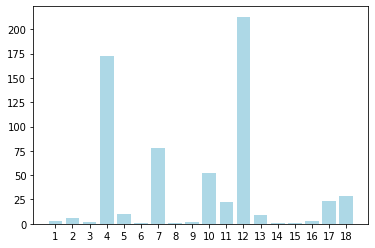

{'Unspecified Attention-Deficit/Hyperactivity Disorder': 3,
 'Specific Learning Disorder with Impairment in Mathematics': 6,
 'Intellectual Disability-Moderate': 2,
 'ADHD-Inattentive Type': 173,
 'Intellectual Disability-Mild': 10,
 'Specific Learning Disorder with Impairment in Reading ': 1,
 'Autism Spectrum Disorder': 78,
 'Speech Sound Disorder': 1,
 'Specific Learning Disorder with Impairment in Written Expression': 2,
 'Specific Learning Disorder with Impairment in Reading': 52,
 'Language Disorder': 22,
 'ADHD-Combined Type': 213,
 'Tourettes Disorder': 9,
 'Social (Pragmatic) Communication Disorder': 1,
 ' ': 1,
 'Persistent (Chronic) Motor or Vocal Tic Disorder': 3,
 'ADHD-Hyperactive/Impulsive Type': 23,
 'Other Specified Attention-Deficit/Hyperactivity Disorder': 29}

In [14]:
# Neurodevelopmental Disorders data stats
#create dataset for only ND patients and drop patients with nulls in 'DX_01_Sub', 'DX_01'
ND = eeg_clusters.groupby('DX_01_Cat').get_group('Neurodevelopmental Disorders')
ND = drop_nans_based_on_column(ND, 'DX_01_Sub')
ND = drop_nans_based_on_column(ND, 'DX_01')

# show stats for subcategories in ND data
get_statistics_column(ND, 'DX_01_Sub')

# show stats for 'DX_01' in ND data
get_statistics_column(ND, 'DX_01')

#### Some takeaway points are: 
- Neurodevelopmental Disorders(ND) data not have Nans in Subcategories or Diagnoses and are a lot (833/1305)
- ADHD Subcategory is 577 samples out of 1305 (around 0.44) --> can try to predict that against all

## Predicting ADHD (as a Subcategory)

### predicting ADHD subcat: preprocessing

In [11]:

# create list of subcategories
subcats = list(set(eeg_clusters['DX_01_Sub'].values))
print(subcats)

# create dict to later map ADHD-->1 vs all other subcats-->0
d = { 
 'Attention-Deficit/Hyperactivity Disorder' : 1
}
subcats.remove( 'Attention-Deficit/Hyperactivity Disorder')
for subcat in subcats: 
    d[subcat]=0
print(d)

#create ADHD dataset
ADHD = eeg_clusters.copy()
ADHD['DX_01_Sub'] = ADHD['DX_01_Sub'].map(d)

# remove othe diagnoses-related columns
ADHD = ADHD.drop(['DX_01_Cat', 'DX_01'], axis=1)

#rename 'DX_01_Sub'-->'label' column
ADHD = ADHD.rename(columns={'DX_01_Sub': 'label'})

ADHD

[nan, 'Nonadherence to Medical Treatment', 'Intellectual Disability', 'Motor Disorder', 'Autism Spectrum Disorder', 'Past', 'Communication Disorder', 'Attention-Deficit/Hyperactivity Disorder', 'Specific Learning Disorder']
{'Attention-Deficit/Hyperactivity Disorder': 1, nan: 0, 'Nonadherence to Medical Treatment': 0, 'Intellectual Disability': 0, 'Motor Disorder': 0, 'Autism Spectrum Disorder': 0, 'Past': 0, 'Communication Disorder': 0, 'Specific Learning Disorder': 0}


,id,Age,label,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,eyesclosed_fband_delta_absmean_mpari,eyesclosed_fband_delta_absmean_rpari,eyesclosed_fband_delta_relmean_lfront,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
0,NDARFM080VAF,7.623203,0,7.519803,7.043891,6.528158,9.633529,9.989483,9.305804,9.598653,...,0.125251,0.125441,0.133882,0.072295,0.080103,0.161771,0.162017,0.172919,0.093375,0.086876
1,NDARVG148WHV,10.835158,0,2.346685,3.945786,2.962716,3.440606,3.565384,3.023286,10.968235,...,0.859637,0.476218,0.527328,0.440019,0.506425,0.861336,0.477159,0.528370,0.440889,0.404930
2,NDARUY876VL1,7.987451,1,1.281869,1.229748,1.905450,1.768091,1.484286,0.756394,13.132905,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
3,NDARYU323ZDJ,8.096851,0,3.109075,4.803264,2.873502,2.644382,3.884837,2.391569,9.931212,...,0.350058,0.265802,0.342563,0.287435,0.272517,0.352119,0.267367,0.344580,0.289128,0.278771
4,NDARYP516VUU,10.758156,0,3.736577,5.970049,3.462826,4.225793,6.973617,6.719936,5.615468,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,NDARYM334BZ5,16.119438,1,3.743134,3.795633,3.286381,2.779438,3.539956,3.800533,8.565498,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282
1302,NDARJJ817UP1,9.126397,0,5.029233,8.495798,8.156703,9.869929,10.167374,7.998537,12.309035,...,0.773345,0.620713,0.568809,0.370741,0.490682,0.722092,0.579575,0.531112,0.346170,0.423813
1303,NDARYZ986HEW,7.563084,1,2.830657,5.259391,6.724664,4.745513,5.885628,3.160138,13.388712,...,0.954900,0.511584,0.301190,0.360761,0.593757,0.585975,0.313934,0.184825,0.221382,0.238841
1304,NDARPM572ZZV,9.832762,0,3.465377,4.039687,2.988368,5.326977,6.712658,6.641600,9.232106,...,0.252401,0.395706,0.427291,0.195140,0.134998,0.283403,0.444309,0.479773,0.219108,0.154441


In [12]:
# import behavioral data to later get SWAN data, that will be used as a 'baseline' for predicting ADHD
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
behavioral

# get SWAN columns
swan_cols = list(behavioral.filter(like='SWAN').columns)
swan_cols

#get SWAN data
SWAN = behavioral[ ['EID','Sex'] + list(behavioral.filter(like='SWAN').columns)]
#rename id column
SWAN = SWAN.rename(columns={'EID': 'id'})

SWAN

,id,Sex,SWAN_IN_Avg,SWAN_HY_Avg,SWAN_Avg
1,NDARYM832PX3,1,0.000000,1.222222,0.611111
2,NDARNJ687DMC,1,1.222222,0.555555,0.888888
3,NDARRM363BXZ,0,1.444444,0.000000,0.722222
4,NDARUW586LLL,1,2.333333,1.000000,1.666666
5,NDARDC298NW4,0,0.666666,0.111111,0.388888
...,...,...,...,...,...
2092,NDARYZ986HEW,1,-0.666666,1.333333,0.333333
2093,NDARPM572ZZV,0,0.111111,-1.666666,-0.777777
2094,NDARYA955CY1,0,0.333333,0.000000,0.166666
2095,NDARRT283RHB,1,NaN,NaN,NaN


In [13]:
#join on patient id and get ADHD_SWAN dataset

try: 
    ADHD_SWAN = pd.merge(SWAN, ADHD, on='id', how='inner',validate='one_to_one')
except pd.errors.MergeError: 
    SWAN = SWAN.drop_duplicates(subset=['id'], keep='first')
    ADHD = ADHD.drop_duplicates(subset=['id'], keep='first')
    ADHD_SWAN = pd.merge(SWAN, ADHD, on='id', how='inner',validate='one_to_one')

ADHD_SWAN

,id,Sex,SWAN_IN_Avg,SWAN_HY_Avg,SWAN_Avg,Age,label,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
0,NDARFM080VAF,1,-0.111111,2.222222,1.055555,7.623203,0,7.519803,7.043891,6.528158,...,0.125251,0.125441,0.133882,0.072295,0.080103,0.161771,0.162017,0.172919,0.093375,0.086876
1,NDARVG148WHV,0,-0.444444,0.444444,0.000000,10.835158,0,2.346685,3.945786,2.962716,...,0.859637,0.476218,0.527328,0.440019,0.506425,0.861336,0.477159,0.528370,0.440889,0.404930
2,NDARUY876VL1,0,1.333333,1.444444,1.388888,7.987451,1,1.281869,1.229748,1.905450,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
3,NDARYU323ZDJ,1,0.666666,-0.888888,-0.111111,8.096851,0,3.109075,4.803264,2.873502,...,0.350058,0.265802,0.342563,0.287435,0.272517,0.352119,0.267367,0.344580,0.289128,0.278771
4,NDARYP516VUU,1,1.111111,0.555555,0.833333,10.758156,0,3.736577,5.970049,3.462826,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NDARYM334BZ5,0,-1.888888,-3.000000,-2.444444,16.119438,1,3.743134,3.795633,3.286381,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282
1301,NDARJJ817UP1,0,0.444444,-0.222222,0.111111,9.126397,0,5.029233,8.495798,8.156703,...,0.773345,0.620713,0.568809,0.370741,0.490682,0.722092,0.579575,0.531112,0.346170,0.423813
1302,NDARYZ986HEW,1,-0.666666,1.333333,0.333333,7.563084,1,2.830657,5.259391,6.724664,...,0.954900,0.511584,0.301190,0.360761,0.593757,0.585975,0.313934,0.184825,0.221382,0.238841
1303,NDARPM572ZZV,0,0.111111,-1.666666,-0.777777,9.832762,0,3.465377,4.039687,2.988368,...,0.252401,0.395706,0.427291,0.195140,0.134998,0.283403,0.444309,0.479773,0.219108,0.154441


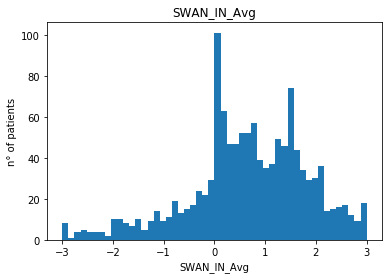

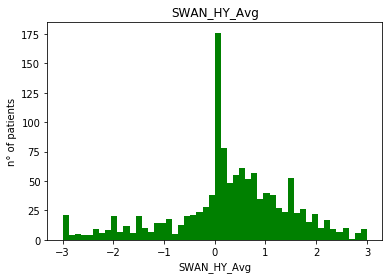

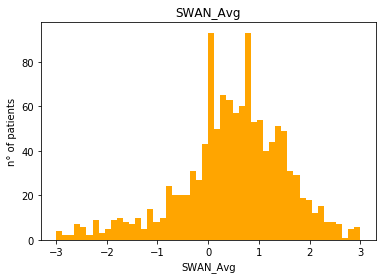

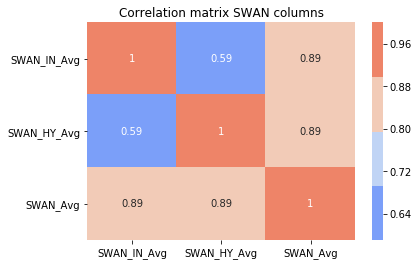

In [14]:
#plot distributions of SWAN columns values

col = 'SWAN_IN_Avg'
plt.title(col)
plt.hist(ADHD_SWAN[col], bins=50)
plt.xlabel(col)
plt.ylabel('n° of patients')
plt.show()

col = 'SWAN_HY_Avg'
plt.title(col)
plt.xlabel(col)
plt.ylabel('n° of patients')
plt.hist(ADHD_SWAN[col], bins=50, color='green')
plt.show()

col = 'SWAN_Avg'
plt.title(col)
plt.xlabel(col)
plt.ylabel('n° of patients')
plt.hist(ADHD_SWAN[col], bins=50, color='orange')
plt.show()

# correlation matrix for SWAN columns
ax = plt.axes()
sns.heatmap(ADHD_SWAN[swan_cols].corr(),annot=True, cmap=sns.color_palette("coolwarm", 4), ax=ax)
ax.set_title('Correlation matrix SWAN columns')
plt.show()


SWAN_Avg is a lor correlated (about 0.9) to the other two SWAN columns. Better drop it. 

In [15]:
#drop SWAN Avg
ADHD_SWAN = ADHD_SWAN.drop('SWAN_Avg',axis=1)
swan_cols.remove('SWAN_Avg')

In [16]:
ADHD_SWAN

,id,Sex,SWAN_IN_Avg,SWAN_HY_Avg,Age,label,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
0,NDARFM080VAF,1,-0.111111,2.222222,7.623203,0,7.519803,7.043891,6.528158,9.633529,...,0.125251,0.125441,0.133882,0.072295,0.080103,0.161771,0.162017,0.172919,0.093375,0.086876
1,NDARVG148WHV,0,-0.444444,0.444444,10.835158,0,2.346685,3.945786,2.962716,3.440606,...,0.859637,0.476218,0.527328,0.440019,0.506425,0.861336,0.477159,0.528370,0.440889,0.404930
2,NDARUY876VL1,0,1.333333,1.444444,7.987451,1,1.281869,1.229748,1.905450,1.768091,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
3,NDARYU323ZDJ,1,0.666666,-0.888888,8.096851,0,3.109075,4.803264,2.873502,2.644382,...,0.350058,0.265802,0.342563,0.287435,0.272517,0.352119,0.267367,0.344580,0.289128,0.278771
4,NDARYP516VUU,1,1.111111,0.555555,10.758156,0,3.736577,5.970049,3.462826,4.225793,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NDARYM334BZ5,0,-1.888888,-3.000000,16.119438,1,3.743134,3.795633,3.286381,2.779438,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282
1301,NDARJJ817UP1,0,0.444444,-0.222222,9.126397,0,5.029233,8.495798,8.156703,9.869929,...,0.773345,0.620713,0.568809,0.370741,0.490682,0.722092,0.579575,0.531112,0.346170,0.423813
1302,NDARYZ986HEW,1,-0.666666,1.333333,7.563084,1,2.830657,5.259391,6.724664,4.745513,...,0.954900,0.511584,0.301190,0.360761,0.593757,0.585975,0.313934,0.184825,0.221382,0.238841
1303,NDARPM572ZZV,0,0.111111,-1.666666,9.832762,0,3.465377,4.039687,2.988368,5.326977,...,0.252401,0.395706,0.427291,0.195140,0.134998,0.283403,0.444309,0.479773,0.219108,0.154441


In [17]:
# dealing with nans 

for column in ADHD_SWAN.columns: 
    nan_sum = ADHD_SWAN.loc[:, column].isna().sum()
    if nan_sum >= 1: 
        print(column, '\t', nan_sum)

SWAN_IN_Avg 	 68
SWAN_HY_Avg 	 68
eyesclosed_alphapeak_max_freq 	 219
eyesclosed_alphapeak_max_amplitude 	 219
eyesclosed_alphapeak_derivative_freq 	 206
eyesclosed_alphapeak_derivative_amplitude 	 206
eyesclosed_fooof_peak_freq_lfront 	 3
eyesclosed_fooof_peak_freq_mfront 	 4
eyesclosed_fooof_peak_freq_rfront 	 3
eyesclosed_fooof_peak_freq_lpari 	 1
eyesclosed_fooof_peak_freq_mpari 	 1
eyesclosed_fooof_peak_freq_rpari 	 3
eyesclosed_fooof_peak_amplitude_lfront 	 3
eyesclosed_fooof_peak_amplitude_mfront 	 4
eyesclosed_fooof_peak_amplitude_rfront 	 3
eyesclosed_fooof_peak_amplitude_lpari 	 1
eyesclosed_fooof_peak_amplitude_mpari 	 1
eyesclosed_fooof_peak_amplitude_rpari 	 3
eyesopen_alphapeak_max_freq 	 429
eyesopen_alphapeak_max_amplitude 	 429
eyesopen_alphapeak_derivative_freq 	 353
eyesopen_alphapeak_derivative_amplitude 	 353
eyesopen_fooof_peak_freq_lfront 	 8
eyesopen_fooof_peak_freq_mfront 	 5
eyesopen_fooof_peak_freq_rfront 	 4
eyesopen_fooof_peak_freq_lpari 	 4
eyesopen_fooof_

### predicting ADHD subact : modelling

In [18]:
# get list for test ids
test_ids = pd.read_csv('data/test_IDS.csv')
test_ids_a = test_ids['ID'].values
test_ids_l = list(test_ids_a)

# split train and test data ADHD_SWAN
ADHD_SWAN_test = ADHD_SWAN.loc[ADHD_SWAN['id'].isin(test_ids_l)]
ADHD_SWAN_train = ADHD_SWAN.loc[~ADHD_SWAN['id'].isin(test_ids_l)]

#pop id and label column train
id_column_train = ADHD_SWAN_train.pop('id')
label_train = ADHD_SWAN_train.pop('label')

#pop id and label column test 
id_column_test = ADHD_SWAN_test.pop('id')
label_test = ADHD_SWAN_test.pop('label')

In [19]:
# dealing with Nans in training data
for column in ADHD_SWAN_train.columns: 
    nan_sum = ADHD_SWAN_train.loc[:, column].isna().sum()
    if nan_sum >= 1: 
        print(column, '\t', nan_sum)
'''
# imputing missing values: strategy= median
from sklearn.impute import SimpleImputer
impute_strategy = 'median'
imputer = SimpleImputer(strategy=impute_strategy)

imputer.fit(ADHD_SWAN_train)
ADHD_SWAN_train = pd.DataFrame(imputer.transform(ADHD_SWAN_train), index=ADHD_SWAN_train.index, columns=ADHD_SWAN_train.columns)
ADHD_SWAN_test = pd.DataFrame(imputer.transform(ADHD_SWAN_test), index=ADHD_SWAN_test.index, columns=ADHD_SWAN_test.columns)

# THIS PART IS REMOVED SINCE THE SCALING IS DONE DIRECTLY IN THE PIPELINE

# scaling data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(ADHD_SWAN_train)

ADHD_SWAN_train = pd.DataFrame(scaler.transform(ADHD_SWAN_train), index=ADHD_SWAN_train.index, columns=ADHD_SWAN_train.columns)
ADHD_SWAN_test = pd.DataFrame(scaler.transform(ADHD_SWAN_test), index=ADHD_SWAN_test.index, columns=ADHD_SWAN_test.columns)
'''

SWAN_IN_Avg 	 63
SWAN_HY_Avg 	 63
eyesclosed_alphapeak_max_freq 	 219
eyesclosed_alphapeak_max_amplitude 	 219
eyesclosed_alphapeak_derivative_freq 	 206
eyesclosed_alphapeak_derivative_amplitude 	 206
eyesclosed_fooof_peak_freq_lfront 	 3
eyesclosed_fooof_peak_freq_mfront 	 4
eyesclosed_fooof_peak_freq_rfront 	 3
eyesclosed_fooof_peak_freq_lpari 	 1
eyesclosed_fooof_peak_freq_mpari 	 1
eyesclosed_fooof_peak_freq_rpari 	 3
eyesclosed_fooof_peak_amplitude_lfront 	 3
eyesclosed_fooof_peak_amplitude_mfront 	 4
eyesclosed_fooof_peak_amplitude_rfront 	 3
eyesclosed_fooof_peak_amplitude_lpari 	 1
eyesclosed_fooof_peak_amplitude_mpari 	 1
eyesclosed_fooof_peak_amplitude_rpari 	 3
eyesopen_alphapeak_max_freq 	 429
eyesopen_alphapeak_max_amplitude 	 429
eyesopen_alphapeak_derivative_freq 	 353
eyesopen_alphapeak_derivative_amplitude 	 353
eyesopen_fooof_peak_freq_lfront 	 8
eyesopen_fooof_peak_freq_mfront 	 5
eyesopen_fooof_peak_freq_rfront 	 4
eyesopen_fooof_peak_freq_lpari 	 4
eyesopen_fooof_

"\n# imputing missing values: strategy= median\nfrom sklearn.impute import SimpleImputer\nimpute_strategy = 'median'\nimputer = SimpleImputer(strategy=impute_strategy)\n\nimputer.fit(ADHD_SWAN_train)\nADHD_SWAN_train = pd.DataFrame(imputer.transform(ADHD_SWAN_train), index=ADHD_SWAN_train.index, columns=ADHD_SWAN_train.columns)\nADHD_SWAN_test = pd.DataFrame(imputer.transform(ADHD_SWAN_test), index=ADHD_SWAN_test.index, columns=ADHD_SWAN_test.columns)\n\n# THIS PART IS REMOVED SINCE THE SCALING IS DONE DIRECTLY IN THE PIPELINE\n\n# scaling data \nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nscaler.fit(ADHD_SWAN_train)\n\nADHD_SWAN_train = pd.DataFrame(scaler.transform(ADHD_SWAN_train), index=ADHD_SWAN_train.index, columns=ADHD_SWAN_train.columns)\nADHD_SWAN_test = pd.DataFrame(scaler.transform(ADHD_SWAN_test), index=ADHD_SWAN_test.index, columns=ADHD_SWAN_test.columns)\n"

#### predicting ADHD using only SWAN (baseline)

In [20]:
# get train and test dataset SWAN columns
X_swan_train = ADHD_SWAN_train[swan_cols]  #only SWAN columns dataset
X_swan_test = ADHD_SWAN_test[swan_cols]

##### SWAN impute strategy='median''

In [126]:
# PIPELINE 1

imp_strategy = 'median'

models = {
    'RidgeClassifier' : 10, 
    'LinearSVC': 10,
    'SVC' : 15,
    'RandomForestClassifier' : 15, 
    'ExtraTreesClassifier' : 15, 
    'AdaBoostClassifier' : 15, 
    'XGBClassifier' : 15
}
results_SWAN, bests_SWAN = one_class_classify_CV(X=X_swan_train, y=label_train, models=models, CV_n_splits=5, verbose=0, impute_strategy=imp_strategy)

# PIPELINE 2 
# decide to go for the accuracy metric of the three
selected_metric = 'balanced_accuracy'

model_classes_dict = {
    'RidgeClassifier' : RidgeClassifier(), 
    'LinearSVC': LinearSVC(),
    'SVC' : SVC(),
    'RandomForestClassifier' : RandomForestClassifier(), 
    'ExtraTreesClassifier' : ExtraTreesClassifier(), 
    'AdaBoostClassifier' : AdaBoostClassifier(), 
    'XGBClassifier' : XGBClassifier()
}

for model_class_name, model_class in model_classes_dict.items():
    parameters = bests_SWAN[model_class_name][selected_metric]['parameters']
    estimator = model_class.set_params(**parameters)
    model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('estimator', estimator)])
    results = cv_one_class_classification(model, X_swan_train, label_train, n_splits=5)
    b_acc_med = np.median(np.array(results['balanced_accuracy']))
    f1_score_med = np.median(np.array(results['f1_score']))
    b_acc_m = np.array(results['balanced_accuracy']).mean()
    f1_score_m = np.array(results['f1_score']).mean()
    print('\n\n',
          model_class_name, '\n\t balanced_accuracy:  mean {} \t median {}' 
          '\n f1_score:  mean {} \t median {} \n\n'.format(b_acc_m, b_acc_med, f1_score_m, f1_score_med))
    
    

trying all possible combiations of parameters for  RidgeClassifier
{'alpha': 1.0}
done  1  out of  10  combinations
{'alpha': 0.5}
done  2  out of  10  combinations
{'alpha': 2.0}
done  3  out of  10  combinations
{'alpha': 1.3}
done  4  out of  10  combinations
{'alpha': 1.1}
done  5  out of  10  combinations
{'alpha': 0.7}
done  6  out of  10  combinations
{'alpha': 1.5}
done  7  out of  10  combinations
RidgeClassifier  done
trying  10  possible combiations of parameters for  LinearSVC
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
non supported combination of parameters
done  1  out of  10  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
done  2  out of  10  combinations
{'C': 2.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': F

In [133]:
# PIPELINE 3
# select best model (manually) and predict on test set 

best_model_class = 'XGBClassifier'

best_model_parameters = bests_SWAN[best_model_class][selected_metric]['parameters']
best_estimator = model_classes_dict[best_model_class].set_params(**best_model_parameters)
best_model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('model', best_estimator)])

best_model.fit(X_swan_train, label_train)
best_model_preds = best_model.predict(X_swan_test)

best_model_test_b_accuracy = balanced_accuracy_score(label_test, best_model_preds)
best_model_test_f1_score= f1_score(label_test, best_model_preds)

print('\n\n Best model results test set: \n balanced_accuracy {} \t f1_score {} \n'.format(best_model_test_b_accuracy, best_model_test_f1_score))



 Best model results test set: 
 balanced_accuracy 0.5398601398601399 	 f1_score 0.6081081081081081 



##### SWAN: impute strategy='mean'

In [34]:
# PIPELINE 1

imp_strategy = 'mean'

models = {
    'RidgeClassifier' : 10, 
    'LinearSVC': 10,
    'SVC' : 15,
    'RandomForestClassifier' : 15, 
    'ExtraTreesClassifier' : 15, 
    'AdaBoostClassifier' : 15, 
    'XGBClassifier' : 15
}
results_SWAN, bests_SWAN = one_class_classify_CV(X=X_swan_train, y=label_train, models=models, CV_n_splits=5, verbose=0, impute_strategy=imp_strategy)

# PIPELINE 2 
# decide to go for the accuracy metric of the three
selected_metric = 'balanced_accuracy'

model_classes_dict = {
    'RidgeClassifier' : RidgeClassifier(), 
    'LinearSVC': LinearSVC(),
    'SVC' : SVC(),
    'RandomForestClassifier' : RandomForestClassifier(), 
    'ExtraTreesClassifier' : ExtraTreesClassifier(), 
    'AdaBoostClassifier' : AdaBoostClassifier(), 
    'XGBClassifier' : XGBClassifier()
}

for model_class_name, model_class in model_classes_dict.items():
    parameters = bests_SWAN[model_class_name][selected_metric]['parameters']
    estimator = model_class.set_params(**parameters)
    model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('estimator', estimator)])
    results = cv_one_class_classification(model, X_swan_train, label_train, n_splits=5)
    b_acc_med = np.median(np.array(results['balanced_accuracy']))
    f1_score_med = np.median(np.array(results['f1_score']))
    b_acc_m = np.array(results['balanced_accuracy']).mean()
    f1_score_m = np.array(results['f1_score']).mean()
    print('\n\n',
          model_class_name, '\n\t balanced_accuracy:  mean {} \t median {}' 
          '\n\t f1_score:  mean {} \t median {} \n\n'.format(b_acc_m, b_acc_med, f1_score_m, f1_score_med))
    
    

trying all possible combiations of parameters for  RidgeClassifier
{'alpha': 1.0}
done  1  out of  10  combinations
{'alpha': 0.5}
done  2  out of  10  combinations
{'alpha': 2.0}
done  3  out of  10  combinations
{'alpha': 1.3}
done  4  out of  10  combinations
{'alpha': 1.5}
done  5  out of  10  combinations
{'alpha': 1.1}
done  6  out of  10  combinations
{'alpha': 0.7}
done  7  out of  10  combinations
RidgeClassifier  done
trying  10  possible combiations of parameters for  LinearSVC
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
non supported combination of parameters
done  1  out of  10  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
done  2  out of  10  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': F

In [35]:
# PIPELINE 3
# select best model (manually) and predict on test set 

best_model_class = 'LinearSVC'

best_model_parameters = bests_SWAN[best_model_class][selected_metric]['parameters']
best_estimator = model_classes_dict[best_model_class].set_params(**best_model_parameters)
best_model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('model', best_estimator)])

best_model.fit(X_swan_train, label_train)
best_model_preds = best_model.predict(X_swan_test)

best_model_test_b_accuracy = balanced_accuracy_score(label_test, best_model_preds)
best_model_test_f1_score= f1_score(label_test, best_model_preds)

print('\n\n Best model results test set: \n balanced_accuracy {} \t f1_score {} \n'.format(best_model_test_b_accuracy, best_model_test_f1_score))



 Best model results test set: 
 balanced_accuracy 0.6272727272727272 	 f1_score 0.6153846153846153 



#### predicting using only EEG 

In [36]:
# get train and test dataset EEG data for ADHD
X_EEGxADHD_train = ADHD_SWAN_train.drop(['Sex','SWAN_IN_Avg','SWAN_HY_Avg','Age'], axis=1)
X_EEGxADHD_test = ADHD_SWAN_test.drop(['Sex','SWAN_IN_Avg','SWAN_HY_Avg','Age'], axis=1)

##### predicting using only EEG: impute strategy 'median'

In [37]:
# PIPELINE 1

imp_strategy = 'median'

models = {
    'RidgeClassifier' : 10, 
    'LinearSVC': 15,
    'SVC' : 20,
    'RandomForestClassifier' : 20, 
    'ExtraTreesClassifier' : 20, 
    'AdaBoostClassifier' : 20, 
    'XGBClassifier' : 20
}
results_EEGxADHD, bests_EEGxADHD = one_class_classify_CV(X=X_EEGxADHD_train, y=label_train, models=models, CV_n_splits=5, verbose=0, impute_strategy=imp_strategy)

# PIPELINE 2 
# decide to go for the accuracy metric of the three
selected_metric = 'balanced_accuracy'

model_classes_dict = {
    'RidgeClassifier' : RidgeClassifier(), 
    'LinearSVC': LinearSVC(),
    'SVC' : SVC(),
    'RandomForestClassifier' : RandomForestClassifier(), 
    'ExtraTreesClassifier' : ExtraTreesClassifier(), 
    'AdaBoostClassifier' : AdaBoostClassifier(), 
    'XGBClassifier' : XGBClassifier()
}

for model_class_name, model_class in model_classes_dict.items():
    parameters = bests_EEGxADHD[model_class_name][selected_metric]['parameters']
    estimator = model_class.set_params(**parameters)
    model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('estimator', estimator)])
    results = cv_one_class_classification(model, X_EEGxADHD_train, label_train, n_splits=5)
    b_acc_med = np.median(np.array(results['balanced_accuracy']))
    f1_score_med = np.median(np.array(results['f1_score']))
    b_acc_m = np.array(results['balanced_accuracy']).mean()
    f1_score_m = np.array(results['f1_score']).mean()
    print('\n\n',
          model_class_name, '\n\t balanced_accuracy:  mean {} \t median {}' 
          '\n\t f1_score:  mean {} \t median {} \n\n'.format(b_acc_m, b_acc_med, f1_score_m, f1_score_med))
    
    

trying all possible combiations of parameters for  RidgeClassifier
{'alpha': 1.1}
done  1  out of  10  combinations
{'alpha': 1.5}
done  2  out of  10  combinations
{'alpha': 2.0}
done  3  out of  10  combinations
{'alpha': 0.5}
done  4  out of  10  combinations
{'alpha': 1.0}
done  5  out of  10  combinations
{'alpha': 0.7}
done  6  out of  10  combinations
{'alpha': 1.3}
done  7  out of  10  combinations
RidgeClassifier  done
trying  15  possible combiations of parameters for  LinearSVC
{'C': 2.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
done  1  out of  15  combinations
{'C': 10.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
non supported combination of parameters
done  2  out of  15  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': 

Split: 5

 ExtraTreesClassifier 
	 balanced_accuracy:  mean 0.5203260540857965 	 median 0.5213996529786004
	 f1_score:  mean 0.35034569651153635 	 median 0.3373493975903615 


Split: 5

 AdaBoostClassifier 
	 balanced_accuracy:  mean 0.5151785382433225 	 median 0.5101937536148062
	 f1_score:  mean 0.4447122432887836 	 median 0.44680851063829785 


Split: 5

 XGBClassifier 
	 balanced_accuracy:  mean 0.5184247085708741 	 median 0.5227370227370227
	 f1_score:  mean 0.5398018352816857 	 median 0.5482625482625483 




In [140]:
# PIPELINE 3
# select best model (manually) and predict on test set 

best_model_class = 'XGBClassifier'

best_model_parameters = bests_EEGxADHD[best_model_class][selected_metric]['parameters']
best_estimator = model_classes_dict[best_model_class].set_params(**best_model_parameters)
best_model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('model', best_estimator)])

best_model.fit(X_EEGxADHD_train, label_train)
best_model_preds = best_model.predict(X_EEGxADHD_test)

best_model_test_b_accuracy = balanced_accuracy_score(label_test, best_model_preds)
best_model_test_f1_score= f1_score(label_test, best_model_preds)
print('\n\n Best model results test set: \n balanced_accuracy {} \t f1_score {} \n'.format(best_model_test_b_accuracy, best_model_test_f1_score))



 Best model results test set: 
 balanced_accuracy 0.5615384615384615 	 f1_score 0.6153846153846154 



In [ ]:
# get feature importances for XGBoost model for EEG 

from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib.pyplot import figure

model = XGBClassifier()
model.set_params(**(bests_EEGxADHD['XGBClassifier']['accuracy']['parameters']))

model.fit(X_EEGxADHD, label_column)

plot_importance(model)
plt.show()

feature_importances = model.feature_importances_

n_features = 5
n_most_imp_feat = feature_importances.argsort()[-n_features:][::-1]

for i, feature in enumerate(X_EEGxADHD.columns): 
    if i in n_most_imp_feat: 
        print(feature, feature_importances[i])

#### predicting using SWAN + EEG + Sex + Age

##### predicting using impute strategy 'median'

In [51]:
# PIPELINE 1

imp_strategy = 'median'

models = {
    'RidgeClassifier' : 10, 
    'LinearSVC': 15,
    'SVC' : 20,
    'RandomForestClassifier' : 20, 
    'ExtraTreesClassifier' : 20, 
    'AdaBoostClassifier' : 20, 
    'XGBClassifier' : 25
}
results_EEGSWAN, bests_EEGSWAN = one_class_classify_CV(X=ADHD_SWAN_train, y=label_train, models=models, CV_n_splits=5, verbose=0, impute_strategy=imp_strategy)

# PIPELINE 2 
# decide to go for the accuracy metric of the three
selected_metric = 'balanced_accuracy'

model_classes_dict = {
    
    'RidgeClassifier' : RidgeClassifier(), 
    'LinearSVC': LinearSVC(),
    'SVC' : SVC(),
    'RandomForestClassifier' : RandomForestClassifier(), 
    'ExtraTreesClassifier' : ExtraTreesClassifier(), 
    'AdaBoostClassifier' : AdaBoostClassifier(), 
    'XGBClassifier' : XGBClassifier()
}

for model_class_name, model_class in model_classes_dict.items():
    parameters = bests_EEGSWAN[model_class_name][selected_metric]['parameters']
    estimator = model_class.set_params(**parameters)
    model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('estimator', estimator)])
    results = cv_one_class_classification(model, ADHD_SWAN_train, label_train, n_splits=5)
    b_acc_med = np.median(np.array(results['balanced_accuracy']))
    f1_score_med = np.median(np.array(results['f1_score']))
    b_acc_m = np.array(results['balanced_accuracy']).mean()
    f1_score_m = np.array(results['f1_score']).mean()
    print('\n\n',
          model_class_name, '\n\t balanced_accuracy:  mean {} \t median {}' 
          '\n\t f1_score:  mean {} \t median {} \n\n'.format(b_acc_m, b_acc_med, f1_score_m, f1_score_med))
    
    

trying all possible combiations of parameters for  RidgeClassifier
{'alpha': 1.5}
done  1  out of  10  combinations
{'alpha': 0.7}
done  2  out of  10  combinations
{'alpha': 2.0}
done  3  out of  10  combinations
{'alpha': 1.1}
done  4  out of  10  combinations
{'alpha': 1.0}
done  5  out of  10  combinations
{'alpha': 0.5}
done  6  out of  10  combinations
{'alpha': 1.3}
done  7  out of  10  combinations
RidgeClassifier  done
trying  15  possible combiations of parameters for  LinearSVC
{'C': 2.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
non supported combination of parameters
done  1  out of  15  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
done  2  out of  15  combinations
{'C': 10.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': 

Split: 5

 RandomForestClassifier 
	 balanced_accuracy:  mean 0.5804897200772249 	 median 0.5719017094017094
	 f1_score:  mean 0.47403875705680754 	 median 0.4795918367346939 


Split: 5

 ExtraTreesClassifier 
	 balanced_accuracy:  mean 0.5678722132033764 	 median 0.5669240669240669
	 f1_score:  mean 0.44955338746407636 	 median 0.46067415730337086 


Split: 5

 AdaBoostClassifier 
	 balanced_accuracy:  mean 0.6755402422079484 	 median 0.673836032388664
	 f1_score:  mean 0.6338413476186249 	 median 0.6421052631578946 


Split: 5

 XGBClassifier 
	 balanced_accuracy:  mean 0.6657318293434936 	 median 0.6688829787234043
	 f1_score:  mean 0.6605151629459909 	 median 0.6639676113360323 




In [147]:
# PIPELINE 3
# select best model (manually) and predict on test set 

best_model_class = 'XGBClassifier'

best_model_parameters = bests_EEGSWAN[best_model_class][selected_metric]['parameters']
best_estimator = model_classes_dict[best_model_class].set_params(**best_model_parameters)
best_model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('model', best_estimator)])

best_model.fit(ADHD_SWAN_train, label_train)
best_model_preds = best_model.predict(ADHD_SWAN_test)


best_model_test_b_accuracy = balanced_accuracy_score(label_test, best_model_preds)
best_model_test_f1_score= f1_score(label_test, best_model_preds)
print('\n\n Best model results test set: \n balanced_accuracy {} \t f1_score {} \n'.format(best_model_test_b_accuracy, best_model_test_f1_score))



 Best model results test set: 
 balanced_accuracy 0.6146853146853146 	 f1_score 0.6178861788617886 



In [65]:
# get feature importances for XGBoost model for SWAN + EEG + Sex + Age 

from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib.pyplot import figure

best_model.fit(ADHD_SWAN_train, label_train)

feature_importances = best_model['model'].feature_importances_

n_features = 10
n_most_imp_feat = feature_importances.argsort()[-n_features:][::-1]

for i, feature in enumerate(ADHD_SWAN.columns): 
    if i in n_most_imp_feat: 
        print(feature, feature_importances[i])

Sex 0.0066834185
eyesclosed_fband_gamma_absmean_rpari 0.013873853
eyesopen_indfband_lower1alpha_relmean_rfront 0.007413112
eyesopen_indfband_upperalpha_relmean_rfront 0.008601207
eyesclosed_ratios_theta_lower2alpha_mfront_mpari 0.007871266
eyesclosed_ratios_theta_lower2alpha_rpari_mpari 0.00757764
eyesclosed_ratios_lower1alpha_lower2alpha_rfront_lfront 0.008069807
eyesclosed_ratios_lower2alpha_beta_lfront_mpari 0.010109274
eyesopen_ratios_theta_lower1alpha_rpari_lfront 0.0082281185
eyesopen_ratios_lower2alpha_beta_mfront_lpari 0.0061662653


In [ ]:
# scatter plot for seemingly most relevant EEG features

figure(figsize = (15,10))
plt.scatter(ADHD_SWAN['eyesclosed_fooof_aperiodic_slope_lfront'], ADHD_SWAN['eyesclosed_fband_alpha_absmean_mfront'], alpha=0.2,
            s=5, c=label_column, cmap='RdBu')
plt.xlabel('eyesclosed_fooof_aperiodic_slope_lfront')
plt.ylabel('eyesclosed_fband_alpha_absmean_mfront')

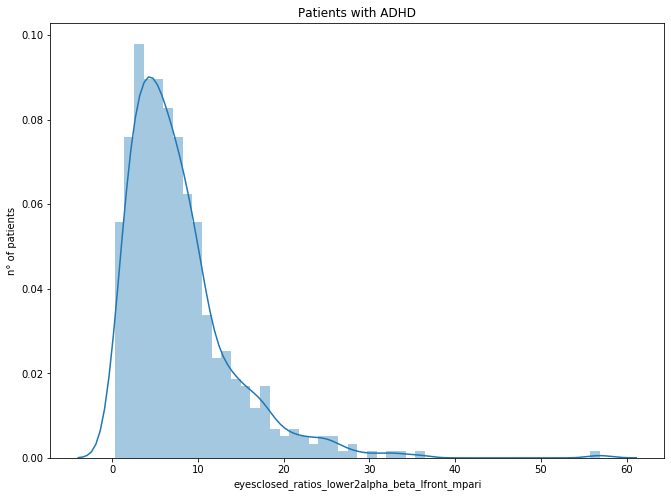

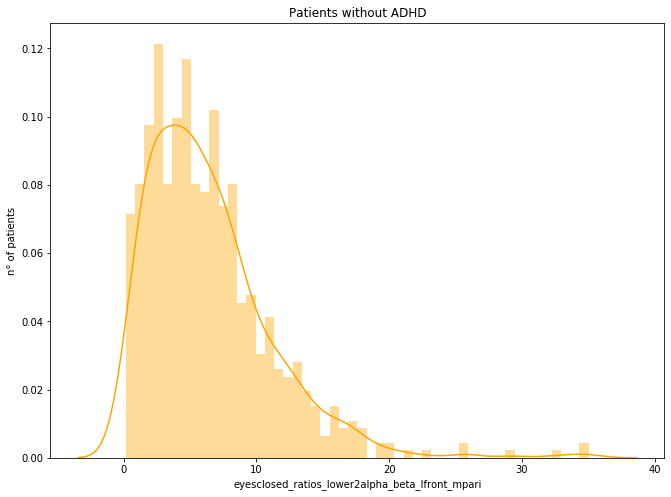

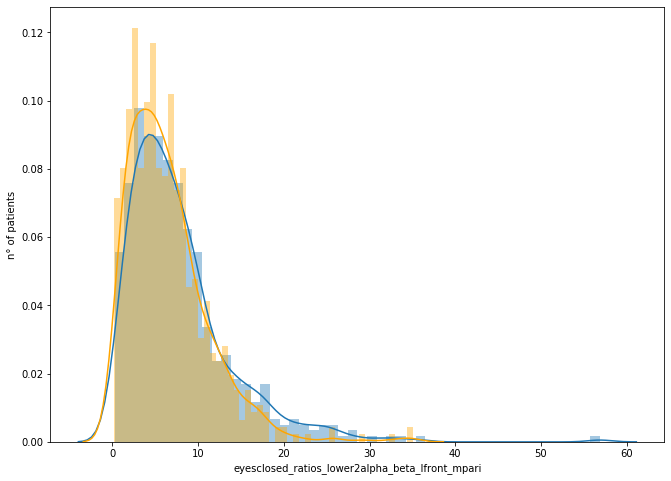

In [64]:
# plot distributons for 'eyesclosed_ratios_lower2alpha_beta_lfront_mpari ' for positive vs negative samples

col_name = 'eyesclosed_ratios_lower2alpha_beta_lfront_mpari'
column = pd.DataFrame(ADHD_SWAN_train['eyesclosed_ratios_lower2alpha_beta_lfront_mpari'], index=ADHD_SWAN_train.index ,columns = ['eyesclosed_ratios_lower2alpha_beta_lfront_mpari'])
column ['label'] = label_train

column_pos = column.loc[column['label'] == 1]
column_neg = column.loc[column['label'] == 0]


figure(figsize = (11,8))
plt.title('Patients with ADHD')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_pos[col_name], bins=50, norm_hist=True)
plt.show()

figure(figsize = (11,8))
plt.title('Patients without ADHD')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_neg[col_name], bins=50, color='orange', norm_hist=True)
plt.show()


figure(figsize = (11,8))
#plt.title('Patients with ADHD')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_pos[col_name], bins=50, norm_hist=True)
#plt.show()
#plt.title('Patients without ADHD')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_neg[col_name], bins=50, color='orange', norm_hist=True)
plt.show()

In [71]:
# see if there is correlation between ratios and ADHD

eeg_clusters_c = eeg_clusters.copy()
# keep only ND and No Diagnoses (healthy)
for row in eeg_clusters_c.index: 
    DX1Cat = eeg_clusters_c.loc[row,'DX_01_Cat'] 
    if DX1Cat != 'Neurodevelopmental Disorders' and DX1Cat != 'No Diagnosis Given':
        eeg_clusters_c.drop(index=[row], inplace=True)

for row in eeg_clusters_c.index: 
    DX1Cat = eeg_clusters_c.loc[row,'DX_01_Cat'] 
    DX1Sub = eeg_clusters_c.loc[row,'DX_01_Sub']
    if DX1Cat == 'Neurodevelopmental Disorders' and DX1Sub != 'Attention-Deficit/Hyperactivity Disorder':
        eeg_clusters_c.drop(index=[row], inplace=True)
        


In [72]:
eeg_clusters_c

,id,Age,DX_01_Cat,DX_01_Sub,DX_01,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,eyesclosed_fband_delta_absmean_mpari,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
2,NDARUY876VL1,7.987451,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Hyperactive/Impulsive Type,1.281869,1.229748,1.905450,1.768091,1.484286,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
4,NDARYP516VUU,10.758156,No Diagnosis Given,NaN,No Diagnosis Given,3.736577,5.970049,3.462826,4.225793,6.973617,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
6,NDARLE953JYU,12.357403,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Inattentive Type,3.519179,5.179898,3.495491,3.629303,4.704654,...,0.412472,0.554367,0.713593,0.409564,0.715958,0.280196,0.376587,0.484751,0.278221,0.297448
7,NDARVN469KP6,16.039356,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,1.551702,2.188666,1.582556,2.293936,4.226975,...,0.435800,0.355654,0.446769,0.284286,0.465297,0.233355,0.190440,0.239228,0.152225,0.177894
11,NDARZY019GNZ,8.784280,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,6.233496,6.755708,9.088227,9.852386,14.023665,...,0.259358,0.329165,0.241075,0.138793,0.096869,0.326961,0.414965,0.303913,0.174970,0.109196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,NDARKK597VDH,13.847022,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,5.514871,7.370924,4.374938,3.186537,8.479133,...,0.177053,0.122052,0.105342,0.170655,0.144049,0.144047,0.099299,0.085704,0.138842,0.086218
1299,NDARND697FLK,6.517796,No Diagnosis Given,NaN,No Diagnosis Given,8.594610,13.258798,7.158682,12.743212,8.698643,...,0.398388,0.253703,0.443967,0.299758,0.538295,0.250718,0.159663,0.279402,0.188647,0.210285
1300,NDARCL008HLA,16.456194,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,7.487871,9.809903,7.255467,8.731814,9.629680,...,0.062755,0.049070,0.053038,0.035425,0.038896,0.096359,0.075345,0.081439,0.054394,0.052210
1301,NDARYM334BZ5,16.119438,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Inattentive Type,3.743134,3.795633,3.286381,2.779438,3.539956,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282


In [72]:
eeg_clusters_c

,id,Age,DX_01_Cat,DX_01_Sub,DX_01,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,eyesclosed_fband_delta_absmean_mpari,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
2,NDARUY876VL1,7.987451,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Hyperactive/Impulsive Type,1.281869,1.229748,1.905450,1.768091,1.484286,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
4,NDARYP516VUU,10.758156,No Diagnosis Given,NaN,No Diagnosis Given,3.736577,5.970049,3.462826,4.225793,6.973617,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
6,NDARLE953JYU,12.357403,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Inattentive Type,3.519179,5.179898,3.495491,3.629303,4.704654,...,0.412472,0.554367,0.713593,0.409564,0.715958,0.280196,0.376587,0.484751,0.278221,0.297448
7,NDARVN469KP6,16.039356,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,1.551702,2.188666,1.582556,2.293936,4.226975,...,0.435800,0.355654,0.446769,0.284286,0.465297,0.233355,0.190440,0.239228,0.152225,0.177894
11,NDARZY019GNZ,8.784280,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,6.233496,6.755708,9.088227,9.852386,14.023665,...,0.259358,0.329165,0.241075,0.138793,0.096869,0.326961,0.414965,0.303913,0.174970,0.109196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,NDARKK597VDH,13.847022,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,5.514871,7.370924,4.374938,3.186537,8.479133,...,0.177053,0.122052,0.105342,0.170655,0.144049,0.144047,0.099299,0.085704,0.138842,0.086218
1299,NDARND697FLK,6.517796,No Diagnosis Given,NaN,No Diagnosis Given,8.594610,13.258798,7.158682,12.743212,8.698643,...,0.398388,0.253703,0.443967,0.299758,0.538295,0.250718,0.159663,0.279402,0.188647,0.210285
1300,NDARCL008HLA,16.456194,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,7.487871,9.809903,7.255467,8.731814,9.629680,...,0.062755,0.049070,0.053038,0.035425,0.038896,0.096359,0.075345,0.081439,0.054394,0.052210
1301,NDARYM334BZ5,16.119438,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Inattentive Type,3.743134,3.795633,3.286381,2.779438,3.539956,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282


In [80]:
sig_ratios = ['eyesclosed_ratios_theta_lower2alpha_mfront_mpari', 
'eyesclosed_ratios_theta_lower2alpha_rpari_mpari', 
'eyesclosed_ratios_lower1alpha_lower2alpha_rfront_lfront',
'eyesclosed_ratios_lower2alpha_beta_lfront_mpari',
'eyesopen_ratios_theta_lower1alpha_rpari_lfront',
'eyesopen_ratios_lower2alpha_beta_mfront_lpari']

eeg_clusters_c['sum_sig_ratios'] = eeg_clusters_c[sig_ratios].sum(axis=1)

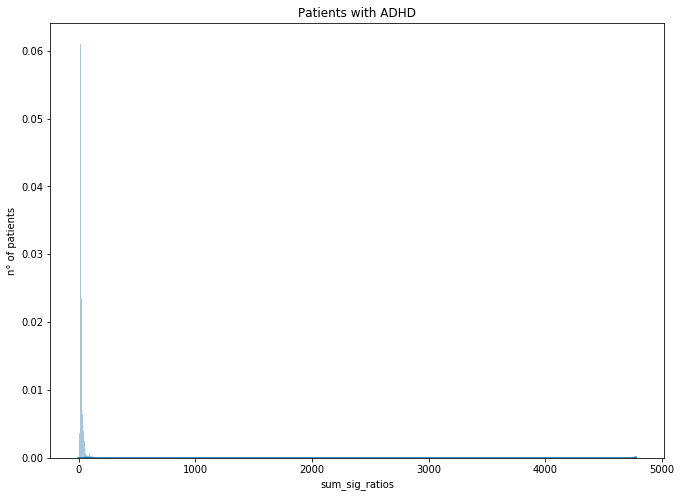

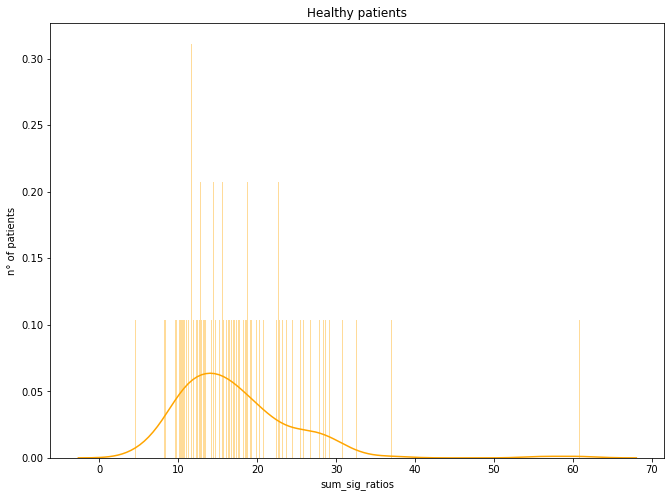

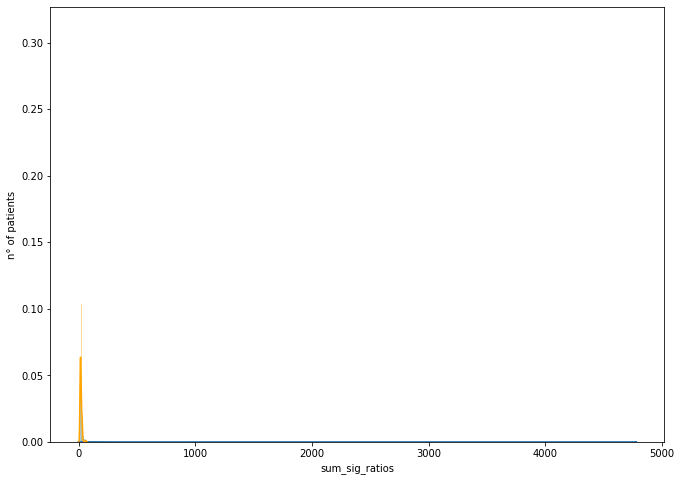

In [84]:
# plot distributons for 'eyesclosed_ratios_lower2alpha_beta_lfront_mpari ' healthy vs ADHD

col_name = 'sum_sig_ratios'
column = pd.DataFrame(eeg_clusters_c[col_name], index=eeg_clusters_c.index ,columns = [col_name])
column ['label'] = eeg_clusters_c['DX_01_Cat']

column_h = column.loc[column['label'] == 'No Diagnosis Given' ]
column_adhd = column.loc[column['label'] == 'Neurodevelopmental Disorders']


figure(figsize = (11,8))
plt.title('Patients with ADHD')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_adhd[col_name], bins=1000, norm_hist=True)
plt.show()

figure(figsize = (11,8))
plt.title('Healthy patients')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_h[col_name], bins=1000, color='orange', norm_hist=True)
plt.show()


figure(figsize = (11,8))
#plt.title('Patients with ADHD')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_adhd[col_name], bins=1000, norm_hist=True)
#plt.show()
#plt.title('Patients without ADHD')
plt.xlabel(col_name)
plt.ylabel('n° of patients')
sns.distplot(column_h[col_name], bins=1000, color='orange', norm_hist=True)
plt.show()

In [111]:
sum_ratios_vs_diag = eeg_clusters_c[['DX_01_Cat', 'sum_sig_ratios']]
for index in sum_ratios_vs_diag.index:
    if sum_ratios_vs_diag.loc[index, 'DX_01_Cat'] == 'Neurodevelopmental Disorders': 
        sum_ratios_vs_diag.loc[index, 'DX_01_Cat'] = 1
    else: 
        sum_ratios_vs_diag.loc[index, 'DX_01_Cat'] = 0
sum_ratios_vs_diag['DX_01_Cat'] = sum_ratios_vs_diag['DX_01_Cat'].astype('int64')


print(sum_ratios_vs_diag)

s_ratios_adhd =sum_ratios_vs_diag.loc[sum_ratios_vs_diag['DX_01_Cat'] == 1 ]['sum_sig_ratios'].values
s_ratios_h =sum_ratios_vs_diag.loc[sum_ratios_vs_diag['DX_01_Cat'] == 0 ]['sum_sig_ratios'].values

print(s_ratios_adhd.mean(),np.median(s_ratios_adhd),  s_ratios_h.mean(), np.median(s_ratios_h))



      DX_01_Cat  sum_sig_ratios
2             1       16.181137
4             0       15.572169
6             1        5.758322
7             1        8.184748
11            1       26.332885
...         ...             ...
1297          1       36.556198
1299          0       18.603225
1300          1       42.525614
1301          1       16.742060
1303          1       11.420752

[748 rows x 2 columns]
35.73300592215449 16.457221580666268 17.264422242504065 15.685394718733061


In [ ]:
# check if the model predicts always the most frequent class

#EEG
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

best_model_svc = SVC().set_params(**(bests_EEGxADHD['SVC']['accuracy']['parameters']))
best_model_xgb = XGBClassifier().set_params(**(bests_EEGxADHD['XGBClassifier']['accuracy']['parameters']))
best_model_et = ExtraTreesClassifier().set_params(**(bests_EEGxADHD['ExtraTreesClassifier']['accuracy']['parameters']))

best_models_list = [best_model_svc, best_model_xgb, best_model_et]

for model in best_models_list: 
    scores = cv_one_class_classification(model, X_EEGxADHD, label_column, n_splits = 5)
    
#SWAN + EEG + Sex + Age

best_model_svc = SVC().set_params(**(bests_SWAN_EEG['SVC']['accuracy']['parameters']))
best_model_xgb = XGBClassifier().set_params(**(bests_SWAN_EEG['XGBClassifier']['accuracy']['parameters']))
best_model_et = ExtraTreesClassifier().set_params(**(bests_SWAN_EEG['ExtraTreesClassifier']['accuracy']['parameters']))

best_models_list = [best_model_svc, best_model_xgb, best_model_et]

for model in best_models_list: 
    scores = cv_one_class_classification(model, ADHD_SWAN, label_column, n_splits = 5)
    


Classifiers do not always predict the most frequent class, which means that model is not 'ill-posed'.

## Predicting diagnosis vs no-diagnosis

We try to predict from EEG data whether a patient is healthy (no-diagnosis given, positive samples) or ill (diagnosis given, negative samples) 

In [112]:

cats = list(set(eeg_clusters['DX_01_Cat'].values))

print(cats)


['Neurocognitive Disorders', 'Schizophrenia Spectrum and other Psychotic Disorders', 'Disruptive', 'Disruptive, Impulse Control and Conduct Disorders', 'Trauma and Stressor Related Disorders', 'No Diagnosis Given', 'Anxiety Disorders', 'Other Conditions That May Be a Focus of Clinical Attention', 'No Diagnosis Given: Incomplete Eval', 'Neurodevelopmental Disorders', 'Elimination Disorders', 'Depressive Disorders', 'Bipolar and Related Disorders', 'Obsessive Compulsive and Related Disorders']


In [113]:
# create healthy/ill (HI) dataset

HI = eeg_clusters.copy()

# remove incomplete evaluation
to_drop_inc_eval = []
for sample in HI.index: 
    if HI.loc[sample,'DX_01_Cat'] == 'No Diagnosis Given: Incomplete Eval': 
        to_drop_inc_eval.append(sample)
        

HI = HI.drop(to_drop_inc_eval, axis=0)


In [114]:
d = { 
    'No Diagnosis Given' : 1
}
cats.remove('No Diagnosis Given')
for subcat in subcats: 
    d[subcat]=0
d

{'No Diagnosis Given': 1,
 nan: 0,
 'Nonadherence to Medical Treatment': 0,
 'Intellectual Disability': 0,
 'Motor Disorder': 0,
 'Autism Spectrum Disorder': 0,
 'Past': 0,
 'Communication Disorder': 0,
 'Specific Learning Disorder': 0}

In [115]:
# create label column
HI['DX_01_Cat'] = HI['DX_01_Cat'].map(d).fillna(0).astype('int64')

# remove othe diagnoses-related columns
HI = HI.drop(['DX_01_Sub', 'DX_01'], axis=1)

#rename label column
HI = HI.rename(columns={'DX_01_Cat': 'label'})

HI

,id,Age,label,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,eyesclosed_fband_delta_absmean_mpari,eyesclosed_fband_delta_absmean_rpari,eyesclosed_fband_delta_relmean_lfront,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
0,NDARFM080VAF,7.623203,0,7.519803,7.043891,6.528158,9.633529,9.989483,9.305804,9.598653,...,0.125251,0.125441,0.133882,0.072295,0.080103,0.161771,0.162017,0.172919,0.093375,0.086876
1,NDARVG148WHV,10.835158,0,2.346685,3.945786,2.962716,3.440606,3.565384,3.023286,10.968235,...,0.859637,0.476218,0.527328,0.440019,0.506425,0.861336,0.477159,0.528370,0.440889,0.404930
2,NDARUY876VL1,7.987451,0,1.281869,1.229748,1.905450,1.768091,1.484286,0.756394,13.132905,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
3,NDARYU323ZDJ,8.096851,0,3.109075,4.803264,2.873502,2.644382,3.884837,2.391569,9.931212,...,0.350058,0.265802,0.342563,0.287435,0.272517,0.352119,0.267367,0.344580,0.289128,0.278771
4,NDARYP516VUU,10.758156,1,3.736577,5.970049,3.462826,4.225793,6.973617,6.719936,5.615468,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,NDARYM334BZ5,16.119438,0,3.743134,3.795633,3.286381,2.779438,3.539956,3.800533,8.565498,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282
1302,NDARJJ817UP1,9.126397,0,5.029233,8.495798,8.156703,9.869929,10.167374,7.998537,12.309035,...,0.773345,0.620713,0.568809,0.370741,0.490682,0.722092,0.579575,0.531112,0.346170,0.423813
1303,NDARYZ986HEW,7.563084,0,2.830657,5.259391,6.724664,4.745513,5.885628,3.160138,13.388712,...,0.954900,0.511584,0.301190,0.360761,0.593757,0.585975,0.313934,0.184825,0.221382,0.238841
1304,NDARPM572ZZV,9.832762,0,3.465377,4.039687,2.988368,5.326977,6.712658,6.641600,9.232106,...,0.252401,0.395706,0.427291,0.195140,0.134998,0.283403,0.444309,0.479773,0.219108,0.154441


In [116]:
# split train and test data HI
HI_test = HI.loc[HI['id'].isin(test_ids_l)]
HI_train = HI.loc[~HI['id'].isin(test_ids_l)]

#pop id and label column train
id_column_HI_train = HI_train.pop('id')
label_HI_train = HI_train.pop('label')

#pop id and label column test 
id_column_HI_test = HI_test.pop('id')
label_HI_test = HI_test.pop('label')

In [117]:
HI_train

,Age,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,eyesclosed_fband_delta_absmean_mpari,eyesclosed_fband_delta_absmean_rpari,eyesclosed_fband_delta_relmean_lfront,eyesclosed_fband_delta_relmean_mfront,eyesclosed_fband_delta_relmean_rfront,...,eyesopen_ratios_beta_upperalpha_mpari_lfront,eyesopen_ratios_beta_upperalpha_mpari_mfront,eyesopen_ratios_beta_upperalpha_mpari_rfront,eyesopen_ratios_beta_upperalpha_mpari_lpari,eyesopen_ratios_beta_upperalpha_mpari_rpari,eyesopen_ratios_beta_upperalpha_rpari_lfront,eyesopen_ratios_beta_upperalpha_rpari_mfront,eyesopen_ratios_beta_upperalpha_rpari_rfront,eyesopen_ratios_beta_upperalpha_rpari_lpari,eyesopen_ratios_beta_upperalpha_rpari_mpari
1,10.835158,2.346685,3.945786,2.962716,3.440606,3.565384,3.023286,10.968235,12.461058,12.027227,...,0.859637,0.476218,0.527328,0.440019,0.506425,0.861336,0.477159,0.528370,0.440889,0.404930
2,7.987451,1.281869,1.229748,1.905450,1.768091,1.484286,0.756394,13.132905,11.998897,10.758373,...,0.662087,0.568107,0.314027,0.327595,0.997638,0.325766,0.279525,0.154510,0.161186,0.232327
3,8.096851,3.109075,4.803264,2.873502,2.644382,3.884837,2.391569,9.931212,10.869944,9.878239,...,0.350058,0.265802,0.342563,0.287435,0.272517,0.352119,0.267367,0.344580,0.289128,0.278771
4,10.758156,3.736577,5.970049,3.462826,4.225793,6.973617,6.719936,5.615468,6.878523,5.969710,...,0.301951,0.230498,0.318962,0.163190,0.110702,0.296090,0.226024,0.312770,0.160022,0.184819
5,16.072324,1.299395,1.357050,1.134175,1.956176,4.220487,1.426547,5.701910,5.643901,5.241850,...,1.124910,1.215937,1.221966,0.636815,0.602189,0.676351,0.731081,0.734706,0.382884,0.230693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,16.119438,3.743134,3.795633,3.286381,2.779438,3.539956,3.800533,8.565498,8.383859,9.919429,...,0.246516,0.265210,0.441781,0.260103,0.127183,0.234378,0.252151,0.420028,0.247296,0.136282
1302,9.126397,5.029233,8.495798,8.156703,9.869929,10.167374,7.998537,12.309035,13.955610,13.245454,...,0.773345,0.620713,0.568809,0.370741,0.490682,0.722092,0.579575,0.531112,0.346170,0.423813
1303,7.563084,2.830657,5.259391,6.724664,4.745513,5.885628,3.160138,13.388712,13.121943,12.806999,...,0.954900,0.511584,0.301190,0.360761,0.593757,0.585975,0.313934,0.184825,0.221382,0.238841
1304,9.832762,3.465377,4.039687,2.988368,5.326977,6.712658,6.641600,9.232106,8.499865,7.191917,...,0.252401,0.395706,0.427291,0.195140,0.134998,0.283403,0.444309,0.479773,0.219108,0.154441


In [166]:
# PIPELINE 1

imp_strategy = 'median'

models = {
    #'RidgeClassifier' : 10, 
    'LinearSVC': 100,
    'SVC' : 100,
    #'RandomForestClassifier' : 20, 
    #'ExtraTreesClassifier' : 20, 
    #'AdaBoostClassifier' : 20, 
    #'XGBClassifier' : 20
}
results_HI_EEG, bests_HI_EEG = one_class_classify_CV(X=HI_train, y=label_HI_train, models=models, CV_n_splits=5, verbose=0, impute_strategy=imp_strategy)

# PIPELINE 2 
# decide to go for the accuracy metric of the three
selected_metric = 'balanced_accuracy'

model_classes_dict = {
    
    #'RidgeClassifier' : RidgeClassifier(), 
    'LinearSVC': LinearSVC(),
    'SVC' : SVC(),
    #'RandomForestClassifier' : RandomForestClassifier(), 
    #'ExtraTreesClassifier' : ExtraTreesClassifier(), 
    #'AdaBoostClassifier' : AdaBoostClassifier(), 
    #'XGBClassifier' : XGBClassifier()
}

for model_class_name, model_class in model_classes_dict.items():
    parameters = bests_HI_EEG[model_class_name][selected_metric]['parameters']
    params=make_pipe_model_params_pca(parameters)
    model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()), ('pca',PCA()), ('model_class', model_class)])
    model.set_params(**params)
    results = cv_one_class_classification(model, HI_train, label_HI_train, n_splits=5)
    b_acc_med = np.median(np.array(results['balanced_accuracy']))
    f1_score_med = np.median(np.array(results['f1_score']))
    b_acc_m = np.array(results['balanced_accuracy']).mean()
    f1_score_m = np.array(results['f1_score']).mean()
    print('\n\n',
          model_class_name, '\n\t balanced_accuracy:  mean {} \t median {}' 
          '\n\t f1_score:  mean {} \t median {} \n\n'.format(b_acc_m, b_acc_med, f1_score_m, f1_score_med))
    
    

trying  100  possible combiations of parameters for  LinearSVC
{'C': 0.5, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 1100, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
non supported combination of parameters
done  1  out of  100  combinations
{'C': 5.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 600, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
done  2  out of  100  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 500, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
done  3  out of  100  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 1000, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
non supported combination of parameter

non supported combination of parameters
done  34  out of  100  combinations
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
non supported combination of parameters
done  35  out of  100  combinations
{'C': 2.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 200, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
done  36  out of  100  combinations
{'C': 5.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 500, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
done  37  out of  100  combinations
{'C': 0.2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 1000, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
non supported combinat

non supported combination of parameters
done  67  out of  100  combinations
{'C': 10.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 500, 'penalty': 'l1', 'tol': 0.0001, 'verbose': 0}
done  68  out of  100  combinations
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 300, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
done  69  out of  100  combinations
{'C': 2.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 800, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
done  70  out of  100  combinations
{'C': 0.5, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'n_components': 800, 'penalty': 'l2', 'tol': 0.0001, 'verbose': 0}
done  71  out of  100  combinations
{'C': 5.0, 'class_weight': 

done  2  out of  100  combinations
done  3  out of  100  combinations
non supported combination of parameters
done  4  out of  100  combinations
done  5  out of  100  combinations
done  6  out of  100  combinations
done  7  out of  100  combinations
non supported combination of parameters
done  8  out of  100  combinations
done  9  out of  100  combinations
done  10  out of  100  combinations
non supported combination of parameters
done  11  out of  100  combinations
done  12  out of  100  combinations
done  13  out of  100  combinations
done  14  out of  100  combinations
done  15  out of  100  combinations
non supported combination of parameters
done  16  out of  100  combinations
done  17  out of  100  combinations
done  18  out of  100  combinations
non supported combination of parameters
done  19  out of  100  combinations
done  20  out of  100  combinations
done  21  out of  100  combinations
done  22  out of  100  combinations
done  23  out of  100  combinations
done  24  out of

In [164]:
# PIPELINE 3
# select best model (manually) and predict on test set 

best_model_class = 'SVC'

best_model_parameters = bests_HI_EEG[best_model_class][selected_metric]['parameters']
best_model_params = make_pipe_model_params_pca(best_model_parameters)
best_estimator = model_classes_dict[best_model_class]
best_model = Pipeline([('imputing',SimpleImputer(strategy=imp_strategy)),('scaling', StandardScaler()),('pca',PCA()), ('model_class', best_estimator)])
best_model.set_params(**best_model_params)

best_model.fit(HI_train, label_HI_train)
best_model_preds = best_model.predict(HI_test)


best_model_test_b_accuracy = balanced_accuracy_score(label_HI_test, best_model_preds)
best_model_test_f1_score= f1_score(label_HI_test, best_model_preds)
print('\n\n Best model results test set: \n balanced_accuracy {} \t f1_score {} \n'.format(best_model_test_b_accuracy, best_model_test_f1_score))



 Best model results test set: 
 balanced_accuracy 0.5446205170975813 	 f1_score 0.1764705882352941 



In [58]:

# try with randomized search and multiple metrics instead of my function (NOT WORKING, SLOW)
'''
def rando_search_model_class (X, y, model_class, model_class_name, param_grid, n_combinations):
    
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.model_selection import cross_val_score
    
    inner_cv = KFold(n_splits=5, shuffle=True)   # no random state passed
    outer_cv = KFold(n_splits=5, shuffle=True)   # no random state passed
    
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score), 
           'recall': make_scorer(recall_score)}
    
    # accuracy re-fit and nested scoring
    rgs_acc = RandomizedSearchCV(estimator=model_class, param_distributions=param_grid, n_iter=n_combinations, scoring=scoring, cv=inner_cv, refit='accuracy')
    rgs_acc.fit(X,y)
    model_nested_score_acc = cross_val_score(rgs_acc, X=X, y=y, cv=outer_cv)
    print('DONE ACCURACY')

    # precision re-fit and nested scoring
    rgs_prc = RandomizedSearchCV(estimator=model_class, param_distributions=param_grid, n_iter=n_combinations, scoring=scoring, cv=inner_cv, refit='precision')
    rgs_prc.fit(X,y)
    model_nested_score_prc = cross_val_score(rgs_prc, X=X, y=y, cv=outer_cv)
    print('DONE PRECISION')

    # recall re-fit and nested scoring
    rgs_rec = RandomizedSearchCV(estimator=model_class, param_distributions=param_grid, n_iter=n_combinations, scoring=scoring, cv=inner_cv, refit='recall')
    rgs_rec.fit(X,y)
    model_nested_score_rec = cross_val_score(rgs_rec, X=X, y=y, cv=outer_cv)
    print('DONE RECALL')

    best_models = {
        'accuracy': rgs_acc, 
        'precision': rgs_prc, 
        'recall': rgs_rec
    }
    best_results = {
        'accuracy': [model_nested_score_acc.mean(), model_nested_score_acc.median()],
        'precision': [model_nested_score_prc.mean(), model_nested_score_prc.median()], 
        'recall': [model_nested_score_rec.mean(), model_nested_score_rec.median()]
    }

    return best_models, best_results
    
model_class = ExtraTreesClassifier()
model_class_name = 'ExtraTreesClassifier'

param_grid ={
    'n_estimators' : [200, 250, 300],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 3, 4],
    'bootstrap' : [True, False],
    'class_weight' : ['balanced', 'balanced_subsample'],
    'verbose' : [0],
    'n_jobs' : [3]
    }

best_models,best_results = rando_search_model_class(X_swan_train,label_train, model_class,model_class_name,param_grid, 3 )
'''